# Data fetching

In [87]:
from io import StringIO
import requests

import jax.numpy as np
from jax.random import PRNGKey

import numpy as onp
import pandas as pd

import numpyro
from numpyro.diagnostics import hpdi
from numpyro import handlers
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

In [1]:
isocodes = pd.read_csv('../input/countries-iso-codes/wikipedia-iso-country-codes.csv')
isocodes.columns = isocodes.columns.str.replace(' ', '_').str.lower()
isocodes = isocodes.rename({"english_short_name_lower_case": 'country_name'}, axis=1)

# url = 'https://data.humdata.org/dataset/e1a91ae0-292d-4434-bc75-bf863d4608ba/resource/a636aad6-f40a-4a2c-ab83-7625d7b9d64d/download/acaps_covid19_goverment_measures_dataset.xlsx'
# measures = pd.read_excel(url, sheet_name='Database')
# measures.to_csv('acaps.csv', index=False)

measures = pd.read_csv('acaps.csv')
measures.columns = measures.columns.str.lower()
measures['date_implemented'] = pd.to_datetime(measures['date_implemented'])

measures = measures.merge(isocodes, left_on='iso', right_on='alpha-3_code')
measures

In [2]:
ecdc = (pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv')
        .assign(date=lambda f: f['date'].pipe(pd.to_datetime))
       )

In [3]:
# Apple mobility
# url = 'https://covid19-static.cdn-apple.com/covid19-mobility-data/2007HotfixDev47/v2/en-us/applemobilitytrends-2020-05-03.csv'
# response = requests.get(url)

# apple_mobility = (pd.read_csv(StringIO(response.content.decode())))
# apple_mobility.to_csv('apple.csv', index=False)

apple_mobility = (pd.read_csv('apple.csv')
                  .drop('alternative_name', axis=1)
                  .set_index(['geo_type', 'region', 'transportation_type'])
                  .rename_axis("date", axis=1)
                  .stack()
                  .rename('change')
                  .reset_index('date')
                  .assign(date=lambda f: pd.to_datetime(f['date']))
                  .set_index('date', append=True)
                  )

location_code = ecdc.groupby(['location', 'iso_code']).first().iloc[:, 0].reset_index().iloc[:,:2]

apple_mobility = (apple_mobility
                  .reset_index()
                  .replace({'UK': 'United Kingdom', 'Republic of Korea': 'South Korea', 'Macao': 'Macau'})  # Only missing is Macao
                  .merge(location_code, left_on='region', right_on='location', how='left')
                 .assign(change=lambda f: f['change'].div(100).sub(1)))

apple_mobility = apple_mobility.query('iso_code.notna()')
apple_mobility

,geo_type,region,transportation_type,date,change,location,iso_code
0,country/region,Albania,driving,2020-01-13,0.0000,Albania,ALB
1,country/region,Albania,driving,2020-01-14,-0.0470,Albania,ALB
2,country/region,Albania,driving,2020-01-15,0.0143,Albania,ALB
3,country/region,Albania,driving,2020-01-16,-0.0280,Albania,ALB
4,country/region,Albania,driving,2020-01-17,0.0355,Albania,ALB
...,...,...,...,...,...,...,...
106731,sub-region,Puerto Rico,driving,2020-04-29,-0.6185,Puerto Rico,PRI
106732,sub-region,Puerto Rico,driving,2020-04-30,-0.5901,Puerto Rico,PRI
106733,sub-region,Puerto Rico,driving,2020-05-01,-0.5426,Puerto Rico,PRI
106734,sub-region,Puerto Rico,driving,2020-05-02,-0.5557,Puerto Rico,PRI


In [4]:
# oxford.columns[mask].str.extract(r'(..)_.*', expand=False)

oxford = pd.read_csv('https://github.com/OxCGRT/covid-policy-tracker/raw/master/data/OxCGRT_latest.csv')
oxford.columns = oxford.columns.map(str.lower).str.replace(' ', '_')
oxford['date'] = pd.to_datetime(oxford['date'], format='%Y%m%d')

oxford

,countryname,countrycode,date,c1_school_closing,c1_flag,c2_workplace_closing,c2_flag,c3_cancel_public_events,c3_flag,c4_restrictions_on_gatherings,...,h3_contact_tracing,h4_emergency_investment_in_healthcare,h5_investment_in_vaccines,m1_wildcard,confirmedcases,confirmeddeaths,stringencyindex,stringencyindexfordisplay,legacystringencyindex,legacystringencyindexfordisplay
0,Aruba,ABW,2020-01-01,0.0,NaN,0.0,NaN,0.0,NaN,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.00,0.00
1,Aruba,ABW,2020-01-02,0.0,NaN,0.0,NaN,0.0,NaN,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.00,0.00
2,Aruba,ABW,2020-01-03,0.0,NaN,0.0,NaN,0.0,NaN,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.00,0.00
3,Aruba,ABW,2020-01-04,0.0,NaN,0.0,NaN,0.0,NaN,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.00,0.00
4,Aruba,ABW,2020-01-05,0.0,NaN,0.0,NaN,0.0,NaN,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19017,Kosovo,RKS,2020-04-30,3.0,1.0,2.0,1.0,2.0,1.0,4.0,...,NaN,NaN,NaN,NaN,806.0,22.0,83.6,83.6,82.14,82.14
19018,Kosovo,RKS,2020-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,806.0,22.0,NaN,83.6,NaN,82.14
19019,Kosovo,RKS,2020-05-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,823.0,22.0,NaN,83.6,NaN,82.14
19020,Kosovo,RKS,2020-05-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,851.0,22.0,NaN,83.6,NaN,82.14


In [39]:
ordinal_columns = oxford.columns[oxford.columns.str.contains("^c._.*_.*")]
geographic_columns = oxford.columns[oxford.columns.str.contains('^c._flag')]
strip_measure_name = lambda name: name.split('_')[0]
measures_ix = dict(zip(ordinal_columns.map(strip_measure_name), ordinal_columns.map(lambda s: '_'.join(s.split('_')[1:]))))

oxford_long = (oxford
               .set_index(['countrycode', 'date'])
               [geographic_columns]
               .rename(columns=strip_measure_name)
               .rename_axis('category', axis=1)
               .stack()
               .to_frame('flag')
               .join(oxford.set_index(['countrycode', 'date'])
                     [ordinal_columns]
                     .rename(columns=strip_measure_name)
                     .replace(0, np.nan)
                     .rename_axis('category', axis=1)
                     .stack()
                     .rename('measure'),
                     how='outer'
                    )
              )

oxford_long = (oxford_long
               .rename_axis('variable', axis=1)
               .stack()
               .rename('value'))

print(oxford_long.shape)
print(measures_ix)
oxford_long.loc['FRA']

(97206,)
{'c1': 'school_closing', 'c2': 'workplace_closing', 'c3': 'cancel_public_events', 'c4': 'restrictions_on_gatherings', 'c5': 'close_public_transport', 'c6': 'stay_at_home_requirements', 'c7': 'restrictions_on_internal_movement', 'c8': 'international_travel_controls'}


date        category  variable
2020-01-23  c8        measure     1.0
2020-01-24  c8        measure     1.0
2020-01-25  c8        measure     1.0
2020-01-26  c8        measure     1.0
2020-01-27  c8        measure     1.0
                                 ... 
2020-05-01  c6        flag        1.0
                      measure     2.0
            c7        flag        1.0
                      measure     2.0
            c8        measure     4.0
Name: value, Length: 816, dtype: float64

In [36]:
oxford_long.loc['FRA'].unstack(-2)

category              c1   c2   c3   c4   c5   c6   c7   c8
date       variable                                        
2020-01-23 measure   NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0
2020-01-24 measure   NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0
2020-01-25 measure   NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0
2020-01-26 measure   NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0
2020-01-27 measure   NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0
...                  ...  ...  ...  ...  ...  ...  ...  ...
2020-04-29 measure   3.0  3.0  2.0  4.0  1.0  2.0  2.0  4.0
2020-04-30 flag      1.0  1.0  1.0  1.0  1.0  1.0  1.0  NaN
           measure   3.0  3.0  2.0  4.0  1.0  2.0  2.0  4.0
2020-05-01 flag      1.0  1.0  1.0  1.0  1.0  1.0  1.0  NaN
           measure   3.0  3.0  2.0  4.0  1.0  2.0  2.0  4.0

[163 rows x 8 columns]

# Inference

In [92]:
ix = pd.IndexSlice

country = 'FRA'
mobility_category = 'transit'
# transit is category c5

subset_mobility = apple_mobility.query('iso_code == @country and transportation_type == @mobility_category').set_index('date')['change']
subset_measures = oxford_long.loc[country].loc[ix[:, 'c5']].unstack().query('flag != flag or flag == 1.')['measure']
common_ix = subset_measures.index.union(subset_mobility.index)
subset_measures = subset_measures.reindex(common_ix).fillna(0)
subset_mobility = subset_mobility.reindex(common_ix)

In [83]:
def reparametrize_gamma(mean, std):
    var = std ** 2
    alpha = mean ** 2 / var
    beta = mean / var
    return alpha, beta

def model(measure=None, mobility=None):
    a = numpyro.sample('a', dist.Normal(0., 0.2))
    alpha = numpyro.sample('alpha', dist.Gamma(*reparametrize_gamma(1., 1.))) - np.log(1.05)
#     mobility_0 = numyro.sample('mobility_0', dist.)
    mu = np.exp(- alpha * measure) + a
    sigma = numpyro.sample('sigma', dist.Exponential(1.))
    numpyro.sample('y', dist.Normal(mu, sigma), obs=mobility)

In [84]:
mcmc = MCMC(NUTS(model, dense_mass=True),
            2000, 2000, num_chains=1,
            progress_bar=True)
mcmc.run(PRNGKey(0), measure=subset_measures.to_numpy(), mobility=subset_mobility.to_numpy() + 1.)
mcmc.print_summary()

sample: 100%|██████████| 4000/4000 [00:31<00:00, 128.91it/s, 7 steps of size 6.47e-01. acc. prob=0.89] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.03      0.02      0.03     -0.00      0.07   1331.16      1.00
     alpha      2.40      0.38      2.34      1.86      2.88   1029.98      1.00
     sigma      0.16      0.01      0.16      0.14      0.18   1448.77      1.00

Number of divergences: 0


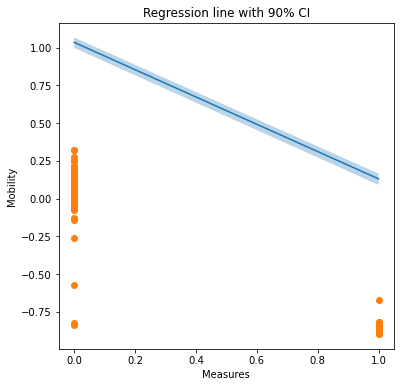

In [91]:
import matplotlib.pyplot as plt

def plot_regression(x, y_mean, y_hpdi):
    # Sort values for plotting by x axis
    idx = np.argsort(x)
    measures = x[idx]
    mean = y_mean[idx]
    hpdi = y_hpdi[:, idx]
    mobility = subset_mobility.to_numpy()[idx]

    # Plot
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    ax.plot(measures, mean)
    ax.plot(measures, mobility, 'o')
    ax.fill_between(measures, hpdi[0], hpdi[1], alpha=0.3, interpolate=True)
    return ax

samples_1 = mcmc.get_samples()

# Compute empirical posterior distribution over mu
posterior_mu = np.expand_dims(samples_1['a'], -1) + \
               np.exp(- np.expand_dims(samples_1['alpha'], -1) * subset_measures.to_numpy())

mean_mu = np.mean(posterior_mu, axis=0)
hpdi_mu = hpdi(posterior_mu, 0.9)
ax = plot_regression(subset_measures.to_numpy(), mean_mu, hpdi_mu)
ax.set(xlabel='Measures', ylabel='Mobility', title='Regression line with 90% CI');